In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types

from transport_problem import OptimParams, DualOracle, HyperParams
from subgd import OracleStacker, ustm_mincost_mcf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# SMALL GRAPH:
# net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
# corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp')
# people_count = corrs.sum()
# corrs = corrs / people_count
# net_df.capacity /= people_count
# graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

#BERLING GRAPH
# BIG_CONST_FOR_FAKE_EDGES = 400
# net_df = get_network_df(Path('SiouxFalls') / 'berlin-center_net.tntp')
# corrs = get_corrs(Path('SiouxFalls') / 'berlin-center_trips.tntp')
# net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
# people_count = corrs.sum()
# corrs = corrs / people_count
# net_df.capacity /= people_count
# net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)

In [55]:
BIG_CONST_FOR_FAKE_EDGES = 4000
net_df = get_network_df(Path('SiouxFalls') / 'ChicagoSketch_net.tntp')
corrs = get_corrs(Path('SiouxFalls') / 'ChicagoSketch_trips.tntp')
print(net_df.free_flow_time.max())
net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
people_count = corrs.sum()
corrs = corrs / people_count
net_df.capacity /= people_count
net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)

24.92


In [56]:
graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

In [57]:
from transport_problem import HyperParams, DualOracle, OptimParams 
l = np.sum(corrs, axis=1)
w = np.sum(corrs, axis=0)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, l, w, params, net_df=net_df)
oracle_stacker = OracleStacker(oracle, graph, sources, targets)

In [58]:
oracle.COUNT_PROCESSES = 6

In [ ]:
results = ustm_mincost_mcf(oracle_stacker,  eps_abs=1e-4, eps_cons_abs=1e-6, max_iter=1000, stop_by_crit=False)

start optimizing
start init y is below t_bar count:  0
start init u is below t_bar count:  0
start init t is below t_bar count:  0


  0%|          | 0/1000 [00:00<?, ?it/s]/home/jupyter/transport/transport_network_optimization/transport_problem.py:168: RuntimeWarning: divide by zero encountered in log
  return np.sum(self.sigma(f)) + self.params.gamma * np.sum(d * np.log(d))
/home/jupyter/transport/transport_network_optimization/transport_problem.py:168: RuntimeWarning: invalid value encountered in multiply
  return np.sum(self.sigma(f)) + self.params.gamma * np.sum(d * np.log(d))
  3%|▎         | 28/1000 [00:11<06:27,  2.51it/s]

In [42]:
a = np.array([1, 2, 3])

True

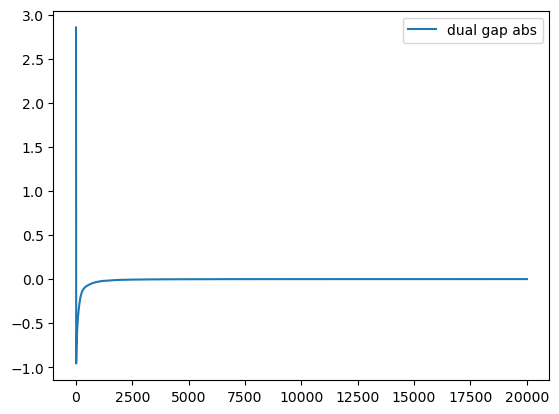

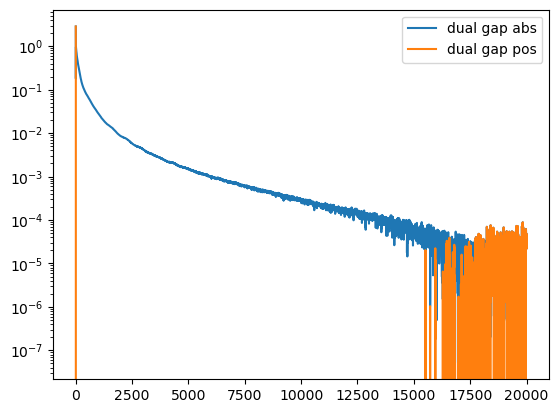

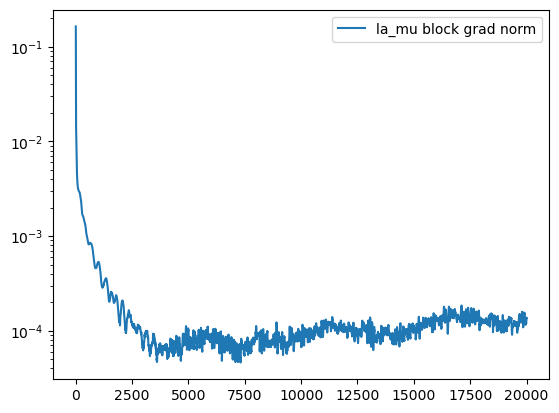

In [41]:
plt.rcParams['figure.dpi']=100
x = results.history_count_calls


plt.plot(x, results.history_dual_gap,  label="dual gap abs")
plt.savefig("plot_ustm_dual_gap abs.png")
# plt.yscale("log")
plt.legend()
plt.show()

plt.plot(x, np.abs(results.history_dual_gap),  label="dual gap abs")
plt.plot(x, results.history_dual_gap,  label="dual gap pos")
plt.savefig("plot_ustm_dual_gap.png")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(x, results.history_la_mu_grad_norm, label="la_mu block grad norm")
plt.savefig("plot_ustm_la_mu_grad_norm.png")
plt.yscale("log")
plt.legend()
plt.show()


# plt.plot(x, results.history_prime_values, label="history prime function")
# plt.legend()
# plt.show()

# plt.plot(x, results.history_dual_values, label="history dual function")
# plt.legend()
# plt.show()



In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())